# LinUCB


In this exercise, we will be experimenting with the stochastic linear bandit problem with the LinUCB algorithm described in chapter 19 in the textbook.

## Setup

The setup is that of section 19.2 in the textbook: At time t, the learner is given the decision set $\mathcal{A}_t \subset \mathbb{R}^d$ from which it chooses an action $A_t \in \mathcal{A}_t$ and receives a reward $$X_t = \langle \theta_*, A_t \rangle + \eta_t, $$ where $\eta_t $ \~ $N(0, 0.25)$, i.e. $\eta_t$ is normally distributed with $0$ mean and $0.25$ variance.

Recall also that the genie reward is defined by $$\max_{a \in \mathcal{A}_t} \langle \theta_*, a \rangle.$$

# Import Dependencies

In [1]:
import numpy as np
from matplotlib import pylab as plt
from tqdm import tqdm

# Reward function
Question: Implement the reward function described in the setup. Specifically, given the set of available arms, implement pull_arm which returns $X_t$ given the index of the arm played. Implement genie_reward which returns the genie reward.

In [2]:
available_arms = np.array([
  (1, 1, 0, 0),
  (1, 0, 1, 0),
  (1, 0, 0, 1),
  (0, 1, 1, 0),
  (0, 1, 0, 1),
  (0, 0, 1, 1)])

class context_arm(object):
    def __init__(self, available_arms=available_arms):
        self.theta = np.array((0.1, 0.4, 0.2, 0.3))
        self.available_arms = np.array(available_arms)

    def pull_arm(self, arm_idx): # Return X_t given the index of the arm played
        reward = self.theta.dot(self.available_arms[arm_idx]) + np.random.randn() / 2
        return reward
  
    def genie_reward(self): # Return the genie reward
        reward = np.max([self.theta.dot(arm) for arm in available_arms]) 
        return reward


## Goal of this exercise

Implement the following using the template provided below. Please use the variable names suggested in the comments.

1. Basic LinUCB algorithm implementation for Gaussian Rewards
2. Plot the expected cumulative regret of the LinUCB algorithm as a function of time.
3. The cumulative regret is expected to be logarithmic against the horizon. To check that this is case, plot the logarithm of the expected cumulative regret of the LinUCB algorithm. (Hint: use the semilogx function in matplotlib.pyplot) 

## LinUCB
Question:

Implement the LinUCB algorithm using the skeleton below. The initialization part is done. Fill out the rest of the skeleton.

In [4]:
class LinUCB():

    def __init__(self, available_arms): # Initialization
        self.arms = available_arms
        self.num_arms = len(self.arms)
        self.d = len(self.arms[0])
        self.reward_history = []
        self.reward_est = np.zeros(self.num_arms)
        self.pull_cnter = np.zeros(self.num_arms)
        self.alpha = 2
        self.V = np.identity(self.d)
        self.b = np.atleast_2d(np.zeros(self.d)).T

    def choose_arm(self): # Compute UCB scores and return the selected arm and its index
        V_inv = np.linalg.inv(self.V)
        theta = np.dot(V_inv, self.b)
        UCB_base = self.arms.dot(theta).T[0]
        UCB_boost = np.zeros(self.num_arms)
        for i in range(self.num_arms):
            cur_arm = self.arms[i,:].reshape(-1,1)
            UCB_boost[i] = np.sqrt(cur_arm.T.dot(V_inv).dot(cur_arm))
        UCB_boost *= self.alpha
        ucbs_score = UCB_base + UCB_boost
        arm_idx = ucbs_score.argmax()
        return self.arms[arm_idx], arm_idx
  
    def update(self, reward, arm_idx): # update the parameters
        self.reward_est[arm_idx] += reward
        self.pull_cnter[arm_idx] += 1
        self.reward_history.append(reward)
        arm = np.atleast_2d(self.arms[arm_idx]).T
        self.V += np.dot(arm, arm.T)
        self.b += reward * arm

# Experiment Function

The following code runs the LinUCB algorithm for multiple instances.

In [5]:
def regret_vs_horizon(REPEAT, HORIZON):
    LinUCB_history = np.zeros(HORIZON)
    my_context_arm = context_arm()
    
    for rep in tqdm(range(REPEAT)):
        LinUCB_instance = LinUCB(available_arms)
        for i in range(HORIZON):
            arm, arm_idx = LinUCB_instance.choose_arm()
            reward = my_context_arm.pull_arm(arm_idx)
            LinUCB_instance.update(reward, arm_idx)
        LinUCB_history += np.array(LinUCB_instance.reward_history)

    LinUCB_expected_reward = LinUCB_history / REPEAT
    LinUCB_expected_reward = np.cumsum(LinUCB_expected_reward)
    best_rewards = my_context_arm.genie_reward()
    best_rewards = best_rewards * np.linspace(1, HORIZON, num=HORIZON)
    LinUCB_regret = best_rewards - LinUCB_expected_reward
    return LinUCB_regret

# Run Experiment

In [6]:
REPEAT = 500
HORIZON = 10000
LinUCB_regret = regret_vs_horizon(REPEAT, HORIZON)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [08:42<00:00,  1.04s/it]


## Plotting the Results

Questions: 

1 - Plot LinUCB_regret against the horizon. Label the x-axis as horizon, and the y-axis as Cumulative Regret. Add a caption labeling this as 'regret vs. horizon: Gaussian Rewards'.

2 - Use the semilogx function in matplotlib to check that the regret is logarithmic against horizon. Ignore the first $1000$ iterations in this case.

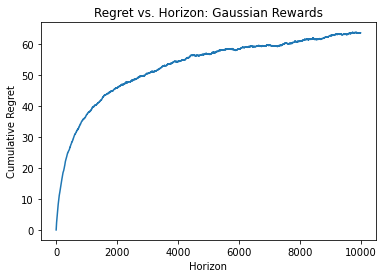

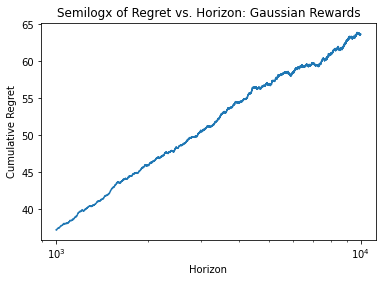

In [7]:
# Plot LinUCB_regret against the horizon
plt.figure()
plt.plot(LinUCB_regret)
plt.xlabel('Horizon')
plt.ylabel('Cumulative Regret')
plt.title('Regret vs. Horizon: Gaussian Rewards')
plt.show()

# Plot the semilogx of LinUCB_regret against the horizon (ignoring first 1000 iterations)
# plt.figure(figsize=(6,4))
plt.figure()
plt.semilogx(range(1000, HORIZON), LinUCB_regret[1000:])
plt.xlabel('Horizon')
plt.ylabel('Cumulative Regret')
plt.title('Semilogx of Regret vs. Horizon: Gaussian Rewards')
plt.show()